In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import seaborn as sns
from scipy.ndimage import center_of_mass
import pandas as pd

from pathlib import Path
import random
import math
from copy import deepcopy
import shutil
from collections import defaultdict

from src.visualise.plot import plot_data, plot_data_simple
from src.data.paths import project_dir
from src.data.analysis import Circle, create_circular_mask
from src.data.detector import find_circle_hough_method, img_for_circle_detection, DetectorDataCollection, DetectorData, DetectorImage

In [2]:
def center_of_mass_det(data: DetectorData) -> tuple[float, float]:
    detector_region = deepcopy(data.raw.image)
    circle_smaller_than_det = Circle(x=data.circle.x, y=data.circle.y, r=data.circle.r * 0.95)
    mask_circle = create_circular_mask(img=detector_region, circle_px=circle_smaller_than_det)
    detector_region[~mask_circle] = 0
    cm = center_of_mass(detector_region)
    return cm

# Data structures

In [4]:
# local paths
base_path = project_dir / 'data' / 'raw'
raw_path = base_path / '2024-09-18'
bg_path = base_path / '2024-09-16'

# # onedrive paths
# base_path = Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils'
# raw_path = base_path / '2024-09-18'
# bg_path = base_path / '2024-09-16'

base_path.exists()

True

In [5]:
proton_raw_data = DetectorDataCollection(path=raw_path)

26 27 28 29 30 31 32 33 34 

In [7]:
co60_path = base_path / '2024-10-29'
co60_raw_data = DetectorDataCollection(path=co60_path)

0 10 11 12 13 14 15 1 2 

3 4 5 6 7 8 9 

In [8]:
bg_raw_data = DetectorDataCollection(path=bg_path)

26 27 28 29 30 31 32 33 34 

## Output paths

In [22]:
base_output_path = project_dir / 'data' / 'interim' / '2024-09-18'  # local 
#base_output_path =  Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils' / 'publication_Measurement_2024' / 'analysis' / 'interim' / '2024-09-18'  # OneDrive

proton_output_path = base_output_path / 'protons'
co60_output_path = base_output_path / 'Co60'
bg_output_path = base_output_path / 'background'

# remove base output path
shutil.rmtree(base_output_path, ignore_errors=True)

# create output paths
proton_output_path.mkdir(parents=True, exist_ok=True)
co60_output_path.mkdir(parents=True)
bg_output_path.mkdir(parents=True, exist_ok=True)

print(f"created {proton_output_path}")

created /home/grzanka/workspace/osl_mb_foils/data/interim/2024-09-18/protons


# Proton raw data

In [23]:
det_id = 15
fig, ax = plot_data_simple(proton_raw_data.data[det_id].raw.image, circle_px=proton_raw_data.data[det_id].lv.init_circle, vmax=1000)

KeyError: 15

KeyError: 15

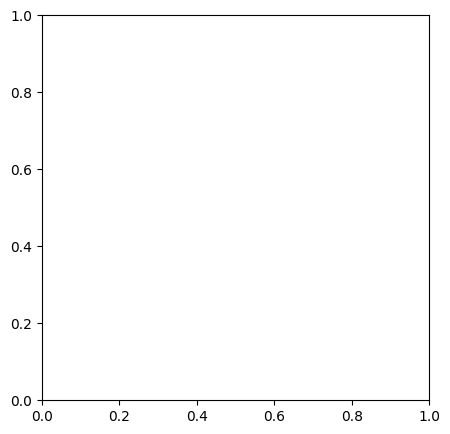

In [24]:
fig, ax = plt.subplots(figsize=(5, 5), facecolor='none')
im = ax.imshow(proton_raw_data.data[det_id].raw.image, cmap='viridis', vmin=450, vmax=1800, interpolation='none')
fig.colorbar(im, ax=ax, shrink=0.6, label='Signal intensity [a.u.]')
fig.tight_layout()

In [25]:
fig, ax = plot_data_simple(
    ndi.median_filter(proton_raw_data.data[det_id].raw.image, size=19), 
    circle_px=proton_raw_data.data[det_id].raw.init_circle, 
    clip=False, vmin=480, vmax=1500)

KeyError: 15

KeyError: 15

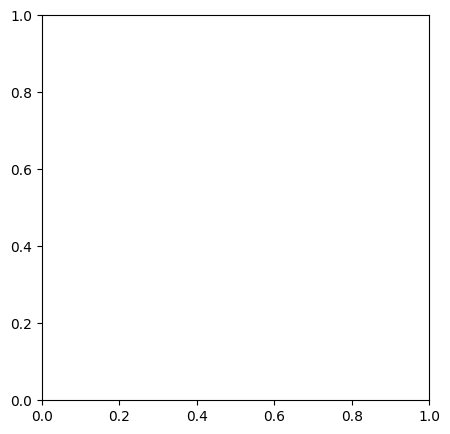

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
bins = np.arange(0, 2000, 10)
mask = create_circular_mask(proton_raw_data.data[det_id].raw.image, proton_raw_data.data[det_id].raw.init_circle)
ax.hist(proton_raw_data.data[det_id].raw.image.flatten(), bins=bins, alpha=0.5, label='raw');
ax.hist(proton_raw_data.data[det_id].raw.image[mask].flatten(), bins=bins, alpha=0.5, label='raw mask');
ax.set_yscale('log')
ax.grid()
ax.legend();

# Co60 raw data

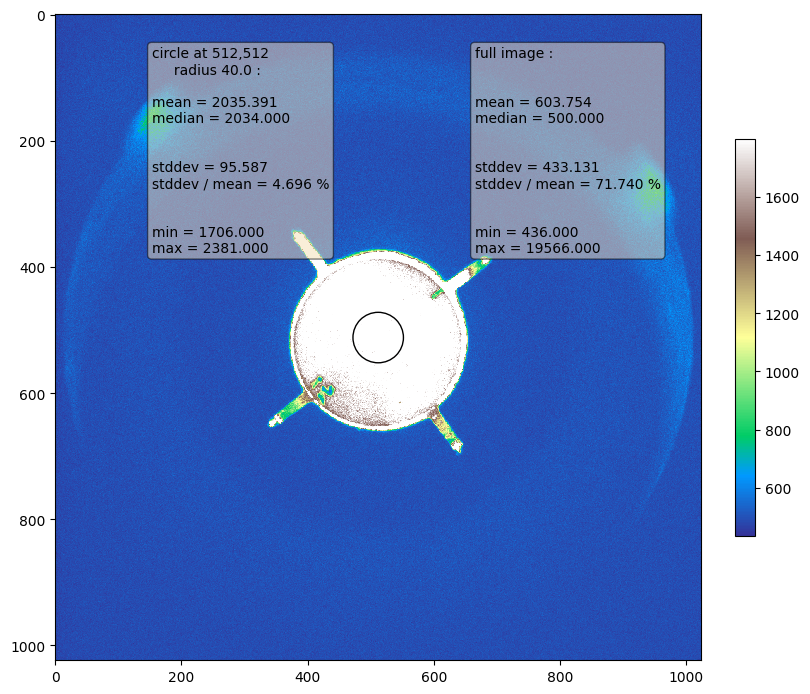

In [27]:
fig, ax = plot_data(co60_raw_data.data[det_id].lv.image, circle_px=co60_raw_data.data[det_id].lv.init_circle)

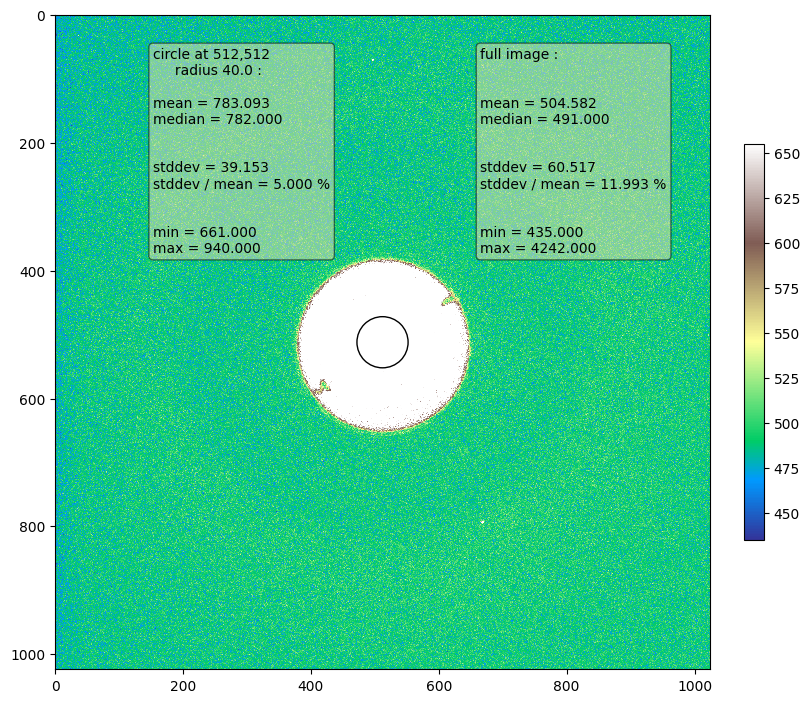

In [28]:
fig, ax = plot_data_simple(co60_raw_data.data[2].raw.image, circle_px=co60_raw_data.data[2].raw.init_circle)

## Background

In [29]:
fig, ax = plot_data(bg_raw_data.data[det_id].lv.image, circle_px=bg_raw_data.data[det_id].lv.init_circle)

KeyError: 15

In [30]:
fig, ax = plot_data(bg_raw_data.data[det_id].raw.image, circle_px=bg_raw_data.data[det_id].raw.init_circle)

KeyError: 15

In [37]:
co60_raw_data.data.keys()

dict_keys([0, 10, 11, 12, 13, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [39]:
# background_path = next((project_dir / 'data' / 'raw' / '2024-02-20').parent.glob('**/*background*/**/**/*tif'))
# background_data = DetectorImage(path=background_path, image=read_tiff_img(background_path, border_px=0))
#background_data = bg_raw_data.data[det_id].raw
background_data = co60_raw_data.data[0].raw

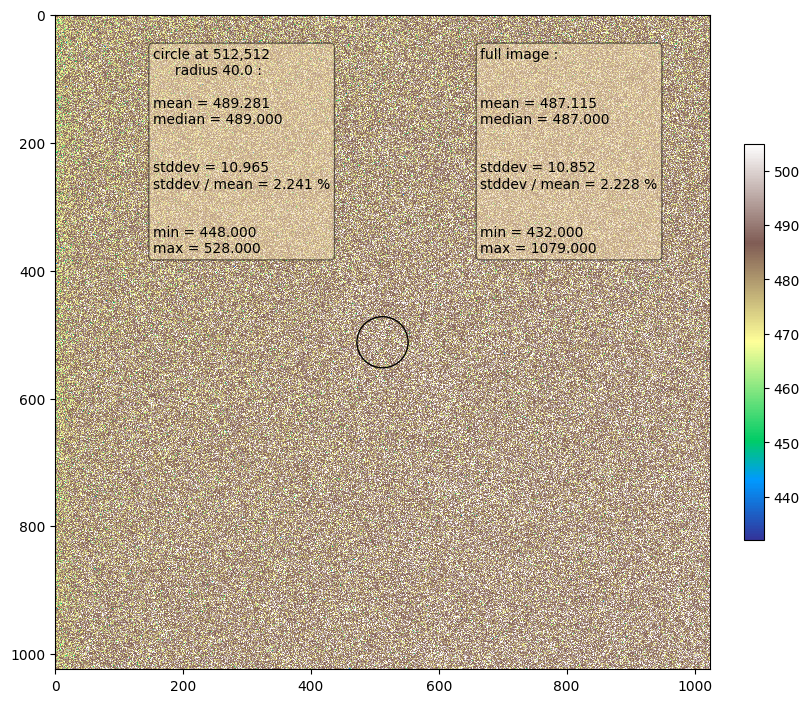

In [40]:
fig, ax = plot_data(background_data.image, circle_px=background_data.init_circle)

# Save plots

## Save LV without detector

In [18]:
for plot_output_path, dataset in zip(
    [proton_output_path, co60_output_path, bg_output_path],
    [proton_raw_data, co60_raw_data, bg_raw_data]):

# for plot_output_path, dataset in zip(
#     [proton_output_path, bg_output_path],
#     [proton_raw_data, bg_raw_data]):

    # save plots from all detectors
    plot_path = plot_output_path / 'live_view'
    plot_path.mkdir(parents=True, exist_ok=True)

    # set vmin to the 5% centile of all images and vmax to 95% centile
    concatenated_flattened_lv_data = np.concatenate([data.lv.image.flatten() for data in dataset.data.values()])
    vmin = np.nanpercentile(a=concatenated_flattened_lv_data, q=5)
    vmax = np.nanpercentile(a=concatenated_flattened_lv_data, q=95)
    print(f"vmin: {vmin}, vmax: {vmax}")

    for det_no, data in dataset.data.items():
        output_path = plot_path / f'lv_det{det_no:02d}'
        output_path.unlink(missing_ok=True)
        #print(f"Saving detector {det_no} / {len(dataset.data)} into {output_path}")
        fig, ax = plot_data_simple(data.lv.image, circle_px=data.lv.init_circle, vmin=vmin, vmax=vmax, clip=False)
        ax.set_title(f"Detector {det_no}")
        fig.savefig(output_path)
        plt.close(fig)

vmin: 482.0, vmax: 3368.0
vmin: 477.0, vmax: 1835.0
vmin: 483.0, vmax: 3534.0


## Save raw data without detector

In [20]:
for plot_output_path, dataset in zip(
    [proton_output_path, co60_output_path, bg_output_path],
    [proton_raw_data, co60_raw_data, bg_raw_data]):

    # save plots from all detectors
    plot_path = plot_output_path / 'raw_data'
    plot_path.mkdir(parents=True, exist_ok=True)

    # get vmax from 90% centile of all images in the circle
    vmax_list = []
    for data in dataset.data.values():
        mask = create_circular_mask(data.raw.image, data.raw.init_circle)
        percentile = np.nanpercentile(a=data.raw.image[mask], q=90)
        vmax_list.append(percentile)
    vmax = max(vmax_list)

    concatenated_flattened_data = np.concatenate([data.raw.image.flatten() for data in dataset.data.values()])
    vmin = np.nanpercentile(a=concatenated_flattened_data, q=3)
    print(f"vmin: {vmin}, vmax: {vmax}")

    for det_no, data in dataset.data.items():
        output_path = plot_path / f'raw_data_det{det_no:02d}'
        output_path.unlink(missing_ok=True)
        fig, ax = plot_data_simple(data.raw.image, circle_px=data.raw.init_circle, vmin=vmin, vmax=vmax, clip=False)
        ax.set_title(f"Detector {det_no}")
        fig.savefig(output_path)
        plt.close(fig)

vmin: 471.0, vmax: 5188.6
vmin: 469.0, vmax: 851.0
vmin: 468.0, vmax: 511.0


# Background subtraction

In [41]:
proton_bg_sub_data = DetectorDataCollection(path=proton_raw_data.path, data=deepcopy(proton_raw_data.data))
for data in proton_bg_sub_data.data.values():
    # out data are save as uint16, dataclasses are frozen
    # its not straightforward to use np.crop(0) or cast to int64
    # therefore we shift data up, perform background subtraction, crop negative values and shift back
    np.add(data.raw.image, background_data.image.max(), out=data.raw.image)    
    np.subtract(data.raw.image, background_data.image, out=data.raw.image)
    np.clip(data.raw.image, a_min=background_data.image.max(), a_max=None, out=data.raw.image)
    np.subtract(data.raw.image, background_data.image.max(), out=data.raw.image)


In [42]:
co60_bg_sub_data = DetectorDataCollection(path=co60_raw_data.path, data=deepcopy(co60_raw_data.data))
for data in co60_bg_sub_data.data.values():

    # out data are save as uint16, dataclasses are frozen
    # its not straightforward to use np.crop(0) or cast to int64
    # therefore we shift data up, perform background subtraction, crop negative values and shift back
    np.add(data.raw.image, background_data.image.max(), out=data.raw.image)    
    np.subtract(data.raw.image, background_data.image, out=data.raw.image)
    np.clip(data.raw.image, a_min=background_data.image.max(), a_max=None, out=data.raw.image)
    np.subtract(data.raw.image, background_data.image.max(), out=data.raw.image)

In [43]:
fig, ax = plot_data_simple(proton_raw_data.data[det_id].raw.image, circle_px=proton_raw_data.data[det_id].raw.init_circle)

KeyError: 15

In [44]:
fig, ax = plot_data(proton_bg_sub_data.data[det_id].raw.image, circle_px=proton_bg_sub_data.data[det_id].raw.init_circle)

KeyError: 15

In [45]:
for plot_output_path, dataset in zip(
    [proton_output_path, co60_output_path],
    [proton_bg_sub_data, co60_bg_sub_data]):

    # save plots from all detectors
    plot_path = plot_output_path / 'bg_sub_data'
    plot_path.mkdir(parents=True, exist_ok=True)

    # get vmax from 90% centile of all images in the circle
    vmax_list = []
    for data in dataset.data.values():
        mask = create_circular_mask(data.raw.image, data.raw.init_circle)
        percentile = np.nanpercentile(a=data.raw.image[mask], q=90)
        vmax_list.append(percentile)
    vmax = max(vmax_list)

    concatenated_flattened_data = np.concatenate([data.raw.image.flatten() for data in dataset.data.values()])
    vmin = np.nanpercentile(a=concatenated_flattened_data, q=3)
    print(f"vmin: {vmin}, vmax: {vmax}")

    for det_no, data in dataset.data.items():
        output_path = plot_path / f'det{det_no:02d}'
        output_path.unlink(missing_ok=True)
        fig, ax = plot_data_simple(data.raw.image, circle_px=data.raw.init_circle, vmin=vmin, vmax=vmax, clip=False)
        ax.set_title(f"Detector {det_no}")
        fig.savefig(output_path)
        plt.close(fig)

vmin: 0.0, vmax: 4701.0
vmin: 0.0, vmax: 364.0


/home/grzanka/workspace/osl_mb_foils/src/visualise/plot.py:17: RuntimeWarning: invalid value encountered in scalar divide
  f'stddev / mean = {100. * np.nanstd(data) / np.nanmean(data):.3f} %',


# Detector discovery

In [46]:
det_data_dict = {}
for data in proton_bg_sub_data.data.values():
    lv_for_detect = img_for_circle_detection(data.lv.image)
    circle = find_circle_hough_method(lv_for_detect)
    det_data = DetectorData(raw=data.raw, lv=data.lv, det_no=data.det_no, circle=circle)
    det_data_dict[data.det_no] = det_data
    print(f"{data.det_no} ", end='')
proton_det_data = DetectorDataCollection(path=proton_raw_data.path, data=det_data_dict)

26 27 28 29 30 31 32 33 34 

In [47]:
det_data_dict = {}
for data in co60_bg_sub_data.data.values():
    lv_for_detect = img_for_circle_detection(data.lv.image)
    circle = find_circle_hough_method(lv_for_detect)
    det_data = DetectorData(raw=data.raw, lv=data.lv, det_no=data.det_no, circle=circle)
    det_data_dict[data.det_no] = det_data
    print(f"{data.det_no} ", end='')
co60_det_data = DetectorDataCollection(path=co60_raw_data.path, data=det_data_dict)

0 10 11 12 13 14 15 1 2 3 4 5 6 7 8 9 

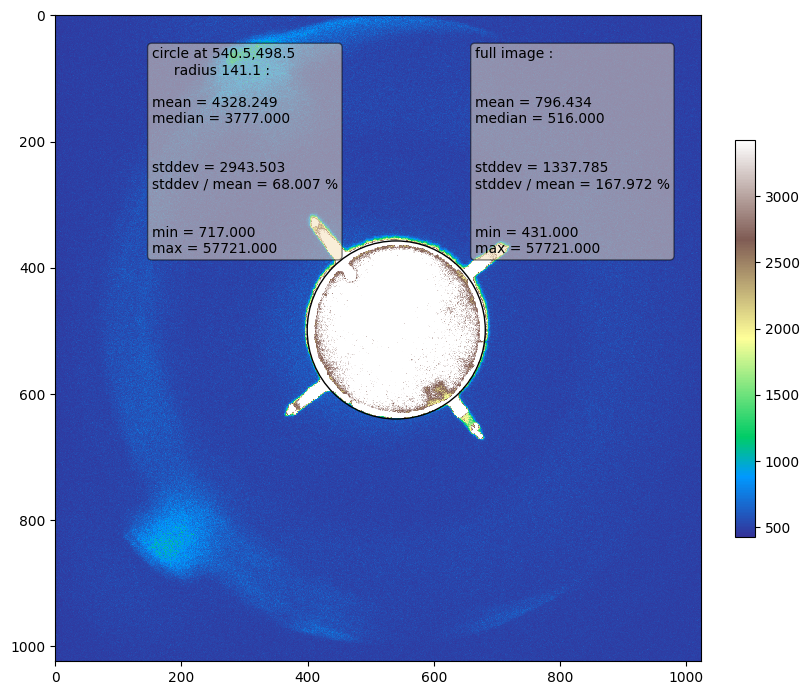

In [27]:
detid = 26 
fig, ax = plot_data(proton_det_data.data[detid].lv.image, circle_px=proton_det_data.data[detid].circle)

In [48]:
mean_radius = np.mean([data.circle.r for data in proton_det_data.data.values()])
mean_radius_mm = 10.0
px_to_mm = mean_radius_mm / mean_radius
px_to_mm

0.07249879204325561

In [29]:
# fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# for data in proton_det_data.data.values():
#     ax[0, 0].plot(data.det_no, data.circle.x, '.')
#     ax[0, 1].plot(data.det_no, data.circle.y, '.')
#     ax[0, 2].plot(data.det_no, data.circle.r, '.')
# for data in co60_det_data.data.values():
#     ax[1, 0].plot(data.det_no, data.circle.x, '.')
#     ax[1, 1].plot(data.det_no, data.circle.y, '.')
#     ax[1, 2].plot(data.det_no, data.circle.r, '.')
# for a in ax.flat:
#     a.grid()
# for a in ax[0]:
#     a.set_xlabel('Proton det no')
# for a in ax[1]:
#     a.set_xlabel('Co60 det no')
# for a in ax[:, 0]:
#     a.set_ylabel('Det center x [px]')
# for a in ax[:, 1]:
#     a.set_ylabel('Det center y [px]')
# for a in ax[:, 2]:
#     a.set_ylabel('Det radius [px]')
# fig.tight_layout()

In [30]:
# fig, ax = plt.subplots(2, 3, figsize=(12, 8))
# for data in proton_det_data.data.values():
#     ax[0, 0].plot(data.det_no, data.circle.x * px_to_mm, '.')
#     ax[0, 1].plot(data.det_no, data.circle.y * px_to_mm, '.')
#     ax[0, 2].plot(data.det_no, data.circle.r * px_to_mm, '.')
# for data in co60_det_data.data.values():
#     ax[1, 0].plot(data.det_no, data.circle.x * px_to_mm, '.')
#     ax[1, 1].plot(data.det_no, data.circle.y * px_to_mm, '.')
#     ax[1, 2].plot(data.det_no, data.circle.r * px_to_mm, '.')
# for a in ax.flat:
#     a.grid()
# for a in ax[0]:
#     a.set_xlabel('Proton det no')
# for a in ax[1]:
#     a.set_xlabel('Co60 det no')
# for a in ax[:, 0]:
#     a.set_ylabel('Det center x [mm]')
# for a in ax[:, 1]:
#     a.set_ylabel('Det center y [mm]')
# for a in ax[:, 2]:
#     a.set_ylabel('Det radius [mm]')
# fig.tight_layout()

## Save plots with detector

In [49]:
for plot_output_path, dataset in zip(
    [proton_output_path, co60_output_path],
    [proton_det_data, co60_det_data]):

    # save plots from all detectors
    plot_path = plot_output_path / 'live_view'
    plot_path.mkdir(parents=True, exist_ok=True)

    # set vmin to the 5% centile of all images and vmax to 95% centile
    concatenated_flattened_lv_data = np.concatenate([data.lv.image.flatten() for data in dataset.data.values()])
    vmin = np.nanpercentile(a=concatenated_flattened_lv_data, q=5)
    vmax = np.nanpercentile(a=concatenated_flattened_lv_data, q=95)
    print(f"vmin: {vmin}, vmax: {vmax}")

    for det_no, data in dataset.data.items():
        output_path = plot_path / f'det_lv_det{det_no:02d}'
        output_path.unlink(missing_ok=True)
        fig, ax = plot_data_simple(data.lv.image, circle_px=data.circle, vmin=vmin, vmax=vmax, clip=False)
        ax.set_title(f"Detector {det_no}")
        fig.savefig(output_path)
        print(f"Saving {output_path}")
        plt.close(fig)

vmin: 482.0, vmax: 3368.0
Saving /home/grzanka/workspace/osl_mb_foils/data/interim/2024-09-18/protons/live_view/det_lv_det26
Saving /home/grzanka/workspace/osl_mb_foils/data/interim/2024-09-18/protons/live_view/det_lv_det27
Saving /home/grzanka/workspace/osl_mb_foils/data/interim/2024-09-18/protons/live_view/det_lv_det28
Saving /home/grzanka/workspace/osl_mb_foils/data/interim/2024-09-18/protons/live_view/det_lv_det29
Saving /home/grzanka/workspace/osl_mb_foils/data/interim/2024-09-18/protons/live_view/det_lv_det30
Saving /home/grzanka/workspace/osl_mb_foils/data/interim/2024-09-18/protons/live_view/det_lv_det31
Saving /home/grzanka/workspace/osl_mb_foils/data/interim/2024-09-18/protons/live_view/det_lv_det32
Saving /home/grzanka/workspace/osl_mb_foils/data/interim/2024-09-18/protons/live_view/det_lv_det33
Saving /home/grzanka/workspace/osl_mb_foils/data/interim/2024-09-18/protons/live_view/det_lv_det34
vmin: 477.0, vmax: 1835.0
Saving /home/grzanka/workspace/osl_mb_foils/data/interim/

In [50]:
for plot_output_path, dataset in zip(
    [proton_output_path, co60_output_path],
    [proton_det_data, co60_det_data]):

    # save plots from all detectors
    plot_path = plot_output_path / 'bg_sub_data'
    plot_path.mkdir(parents=True, exist_ok=True)

    # get vmax from 90% centile of all images in the circle
    vmax_list = []
    for data in dataset.data.values():
        mask = create_circular_mask(data.raw.image, data.raw.init_circle)
        percentile = np.nanpercentile(a=data.raw.image[mask], q=90)
        vmax_list.append(percentile)
    vmax = max(vmax_list)

    concatenated_flattened_data = np.concatenate([data.raw.image.flatten() for data in dataset.data.values()])
    vmin = np.nanpercentile(a=concatenated_flattened_data, q=3)
    print(f"vmin: {vmin}, vmax: {vmax}")

    for det_no, data in dataset.data.items():
        output_path = plot_path / f'bg_sub_data_det{det_no:02d}'
        output_path.unlink(missing_ok=True)
        fig, ax = plot_data_simple(data.raw.image, circle_px=data.circle, vmin=vmin, vmax=vmax, clip=False)
        ax.set_title(f"Detector {det_no}")
        fig.savefig(output_path)
        plt.close(fig)

vmin: 0.0, vmax: 4701.0
vmin: 0.0, vmax: 364.0


## Detector cutting

In [54]:
min_radius_protons = min([data.circle.r for data in proton_det_data.data.values()])
min_radius_co60 = min([data.circle.r for data in co60_det_data.data.values()])
min_radius_all = np.floor(min(min_radius_protons, min_radius_co60)).astype(int)

#min_radius_all = min_radius_protons

#print(f"min radius - protons: {min_radius_protons:.2f}, Co60: {min_radius_co60:.2f}, all: {min_radius_all}")
#print(f"min radius - protons: {min_radius_protons * px_to_mm:.2f} [mm], Co60: {min_radius_co60 * px_to_mm:.2f} [mm], all: {min_radius_all * px_to_mm:.2f} [mm]")

In [55]:
def cut_detector(det_data: DetectorData, min_radius: int, factor: float = 1.2) -> DetectorData:
    lower_x = np.ceil(det_data.circle.x - factor*min_radius).astype(int)
    upper_x = np.floor(det_data.circle.x + factor*min_radius).astype(int)
    lower_y = np.ceil(det_data.circle.y - factor*min_radius).astype(int)
    upper_y = np.floor(det_data.circle.y + factor*min_radius).astype(int)
    
    new_circle = Circle(x=det_data.circle.x - lower_x, y=det_data.circle.y - lower_y, r=det_data.circle.r)
    cut_raw_image = det_data.raw.image[lower_y:upper_y, lower_x:upper_x][:]
    cut_lv_image = det_data.lv.image[lower_y:upper_y, lower_x:upper_x][:]

    return DetectorData(raw=DetectorImage(image=cut_raw_image, path=det_data.raw.path), lv=DetectorImage(image=cut_lv_image, path=det_data.lv.path), det_no=det_data.det_no, circle=new_circle)

In [56]:
c1 = cut_detector(proton_det_data.data[det_id], min_radius_all)

fig, ax = plt.subplots(figsize=(5, 5), facecolor='none')
im = ax.imshow(c1.raw.image, cmap='viridis', vmin=0, vmax=1000, interpolation='none')
ax.add_artist(plt.Circle((c1.circle.x, c1.circle.y), c1.circle.r, color='red', fill=False))
fig.colorbar(im, ax=ax, shrink=0.6, label='Signal intensity [a.u.]')
fig.tight_layout()

KeyError: 15

In [57]:
# c1 = cut_detector(co60_det_data.data[2], min_radius_all)
# fig, ax = plot_data(c1.raw.image, circle_px=c1.circle)

In [58]:
det_data_dict = {}
for data in proton_det_data.data.values():
    det_data_dict[data.det_no] = cut_detector(data, min_radius_all)
    print(f"{data.det_no} ", end='')
proton_det_cut_data = DetectorDataCollection(path=proton_det_data.path, data=det_data_dict)

26 27 28 29 30 31 32 33 34 

In [59]:
det_data_dict = {}
for data in co60_det_data.data.values():
    det_data_dict[data.det_no] = cut_detector(data, min_radius_all)
    print(f"{data.det_no} ", end='')
co60_det_cut_data = DetectorDataCollection(path=co60_det_data.path, data=det_data_dict)

0 10 11 12 13 14 15 1 2 3 4 5 6 7 8 9 

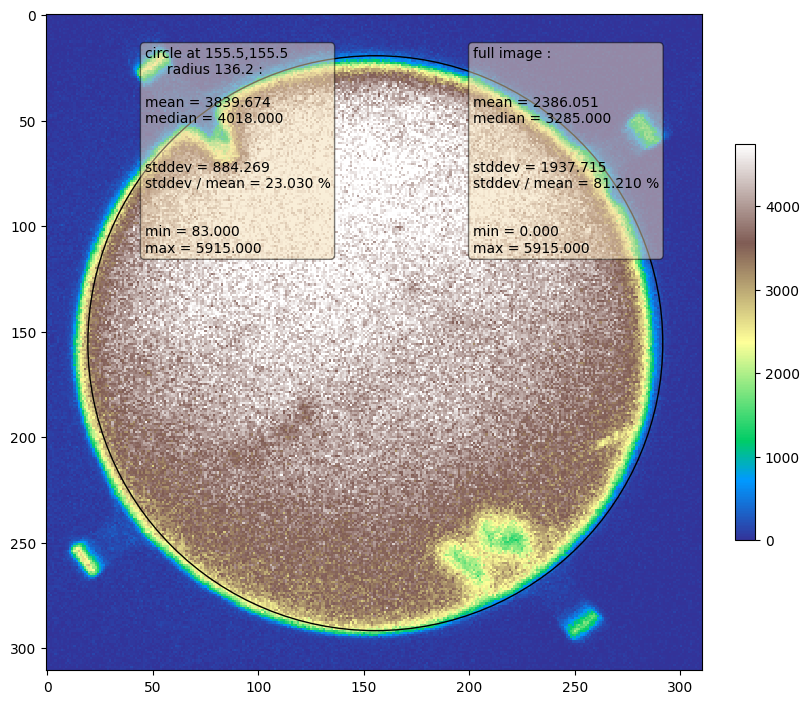

In [39]:
fig, ax = plot_data(proton_det_cut_data.data[det_id].raw.image, circle_px=proton_det_cut_data.data[det_id].circle)

# Center of mass

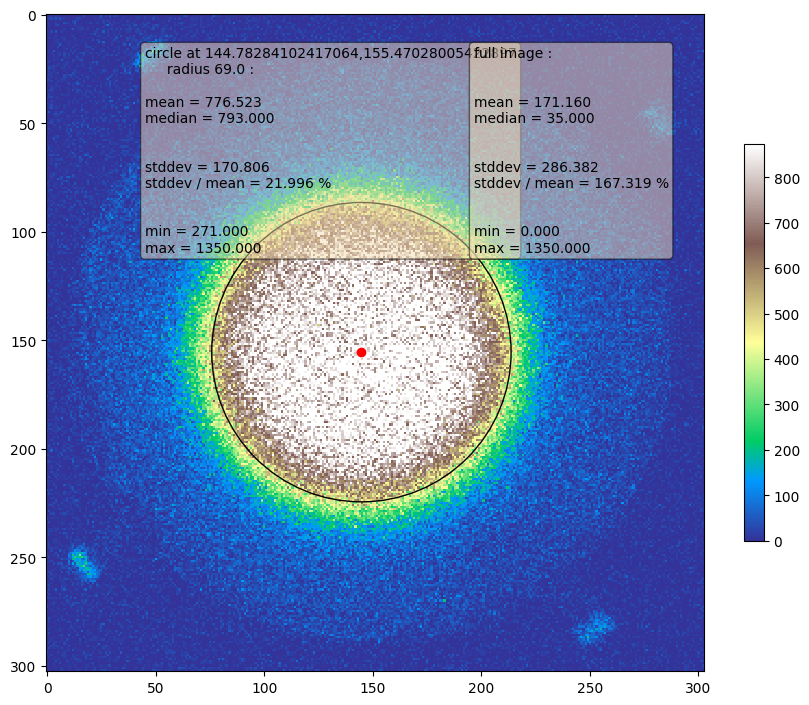

In [60]:
r_px = 5 / px_to_mm

det_id = 26
cm1 = center_of_mass_det(proton_det_cut_data.data[det_id])
cm1_circle = Circle(x=cm1[1], y=cm1[0], r=r_px)
fig, ax = plot_data_simple(proton_det_cut_data.data[det_id].raw.image, circle_px=cm1_circle, clip=True)
ax.plot(cm1[1], cm1[0], 'o', color='red')

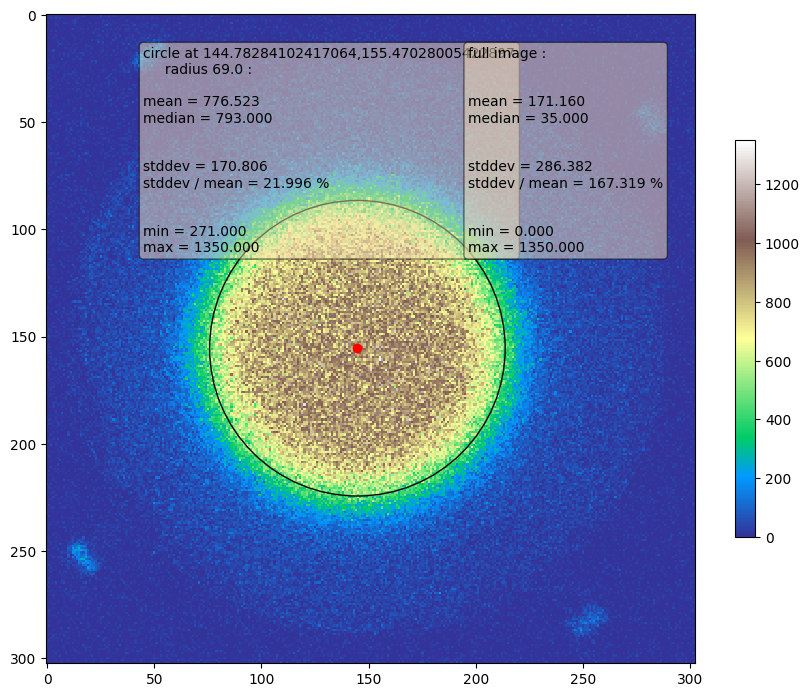

In [61]:
r_px = 5 / px_to_mm

det_id = 26
cm1 = center_of_mass_det(proton_det_cut_data.data[det_id])
cm1_circle = Circle(x=cm1[1], y=cm1[0], r=r_px)
fig, ax = plot_data_simple(proton_det_cut_data.data[det_id].raw.image, circle_px=cm1_circle, clip=False)
ax.plot(cm1[1], cm1[0], 'o', color='red')

In [62]:

for plot_output_path, dataset in zip(
    [proton_output_path, co60_output_path],
    [proton_det_cut_data, co60_det_cut_data]):

# for plot_output_path, dataset in zip(
#     [proton_output_path, ],
#     [proton_det_cut_data, ]):


    # save plots from all detectors
    plot_path = plot_output_path / 'bg_sub_data'
    plot_path.mkdir(parents=True, exist_ok=True)

    # get vmax from 90% centile of all images in the circle
    vmax_list = []
    for data in dataset.data.values():
        mask = create_circular_mask(data.raw.image, data.raw.init_circle)
        percentile = np.nanpercentile(a=data.raw.image[mask], q=90)
        vmax_list.append(percentile)
    vmax = max(vmax_list)

    concatenated_flattened_data = np.concatenate([data.raw.image.flatten() for data in dataset.data.values()])
    vmin = np.nanpercentile(a=concatenated_flattened_data, q=3)
    print(f"vmin: {vmin}, vmax: {vmax}")

    for det_no, data in dataset.data.items():
        output_path = plot_path / f'det_cut_bg_sub_data_det{det_no:02d}'
        output_path.unlink(missing_ok=True)
        fig, ax = plot_data_simple(data.raw.image, circle_px=data.circle, vmin=vmin, vmax=vmax, clip=False)

        # detectors 26-28 were used with 10mm collimator
        r_mm = 10
        if det_no in {26,27,28}:
            r_mm = 5

        r_px = r_mm / px_to_mm

        cm = center_of_mass_det(data)
        cm_circle = Circle(x=cm[1], y=cm[0], r=r_px)
        ax.plot(cm[1], cm[0], 'o', color='red')
        ax.add_artist(
            plt.Circle(xy=(cm_circle.x, cm_circle.y),
                   radius=cm_circle.r,
                   color='red',
                   fill=False,
                   transform=ax.transData))

        ax.set_title(f"Detector {det_no}")
        fig.savefig(output_path)
        plt.close(fig)

vmin: 0.0, vmax: 4762.0
vmin: 0.0, vmax: 360.0


/home/grzanka/workspace/osl_mb_foils/src/visualise/plot.py:17: RuntimeWarning: invalid value encountered in scalar divide
  f'stddev / mean = {100. * np.nanstd(data) / np.nanmean(data):.3f} %',
/home/grzanka/workspace/osl_mb_foils/.venv/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


In [63]:
# Save numpy data to disk for calculation of profiles

# for plot_output_path, dataset in zip(
#     [proton_output_path, co60_output_path],
#     [proton_det_cut_data, co60_det_cut_data]):

for plot_output_path, dataset in zip(
    [proton_output_path, ],
    [proton_det_cut_data, ]):
    npy_path = plot_output_path / 'bg_sub_data'
    npy_path.mkdir(parents=True, exist_ok=True)
    for det_no, data in dataset.data.items():
        output_path = npy_path / f'data_det{det_no:02d}'
        np.save(arr=data.raw.image, file=output_path)

# Mean signal inspection

In [64]:
min_radius_all
singal_radius = 0.5 * min_radius_all
singal_radius

63.5

In [65]:
df_data = defaultdict(list)
for data in proton_det_cut_data.data.values():
    #mask = create_circular_mask(img=data.raw.image, circle_px=Circle(x=data.circle.x, y=data.circle.y, r=singal_radius))
    cm = center_of_mass_det(data)
    cm_circle = Circle(x=cm[1], y=cm[0], r=60)
    mask = create_circular_mask(img=data.raw.image, circle_px=cm_circle)
    df_data["det_no"] += [int(data.det_no)]
    df_data["mean_signal"] += [np.mean(data.raw.image[mask])]
    df_data["std_signal"] += [np.std(data.raw.image[mask])]
    df_data["radiation"] += ["proton"]
for data in co60_det_cut_data.data.values():
    mask = create_circular_mask(img=data.raw.image, circle_px=Circle(x=data.circle.x, y=data.circle.y, r=singal_radius))
    df_data["det_no"] += [int(data.det_no)]
    df_data["mean_signal"] += [np.mean(data.raw.image[mask])]
    df_data["std_signal"] += [np.std(data.raw.image[mask])]
    df_data["radiation"] += ["Co60"]
df = pd.DataFrame(df_data)
df.sort_values(by=["radiation","det_no"], inplace=True)
df

det_no  mean_signal  std_signal radiation
9        0     0.000000    0.000000      Co60
16       1   281.800221   41.251065      Co60
17       2   288.890304   41.214212      Co60
18       3   277.973110   40.289661      Co60
19       4   284.657545   40.604684      Co60
20       5   294.126463   42.774236      Co60
21       6   285.327586   41.208731      Co60
22       7   292.157624   40.776168      Co60
23       8   281.103844   40.805974      Co60
24       9   280.751503   41.298476      Co60
10      10   280.852341   39.862157      Co60
11      11   265.937203   38.770282      Co60
12      12   285.653512   41.130279      Co60
13      13   294.410630   41.506118      Co60
14      14   301.193768   42.304654      Co60
15      15   275.952072   39.716114      Co60
0       26   842.963863  127.468835    proton
1       27   869.506326  128.082217    proton
2       28   803.879841  122.531579    proton
3       29   232.665488   57.873966    proton
4       30   452.951021   79.393260    proton
5       31   935.532344  121.211942    proton
6       32  2339.498541  204.659428    proton
7       33  3575.761050  243.670724    proton
8       34  4386.935769  323.508523    proton

<Axes: xlabel='det_no'>

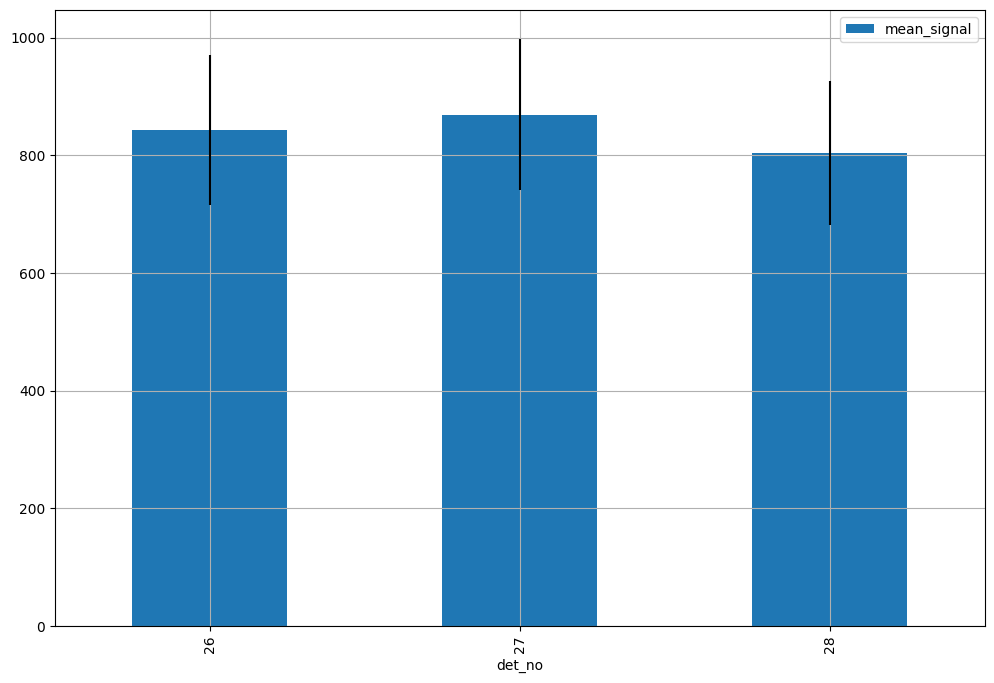

In [66]:
df.query("radiation == 'proton' & det_no <= 28").plot(x='det_no', y='mean_signal', yerr='std_signal', kind='bar', figsize=(12, 8), grid=True)

<Axes: xlabel='det_no'>

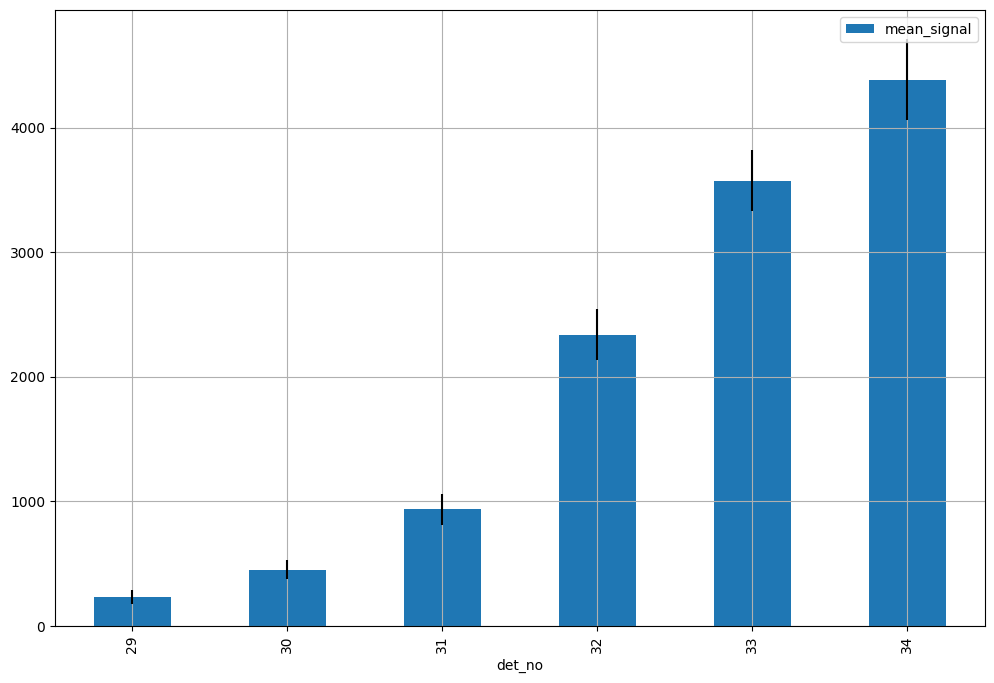

In [67]:
df.query("radiation == 'proton' & det_no > 28").plot(x='det_no', y='mean_signal', yerr='std_signal', kind='bar', figsize=(12, 8), grid=True)

<Axes: xlabel='det_no'>

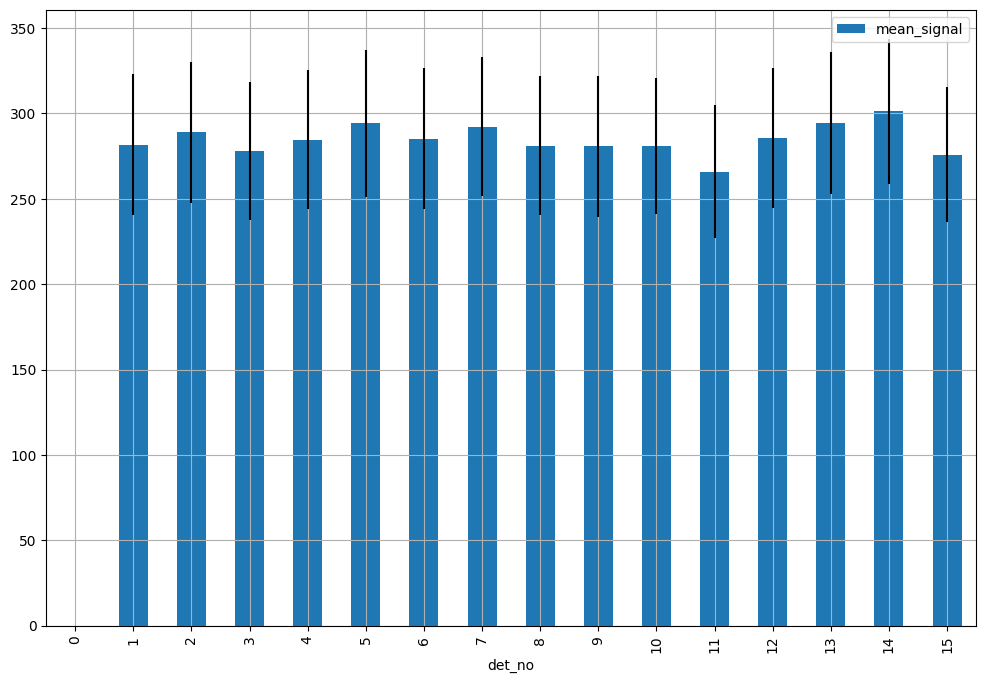

In [68]:
df[df.radiation == 'Co60'].plot(x='det_no', y='mean_signal', yerr='std_signal', kind='bar', figsize=(12, 8), grid=True)

# EBT3 dataset selection

In [49]:
det_data_dict = {}
for data in proton_det_cut_data.data.values():
    if data.det_no in {26,27,28}:
        det_data_dict[data.det_no] = data
        print(f"{data.det_no} ", end='')
proton_det_sel_data = DetectorDataCollection(path=proton_det_cut_data.path, data=det_data_dict)

26 27 28 

In [50]:
# det_data_dict = {}
# for data in co60_det_cut_data.data.values():
#     if data.det_no >= 2 and data.det_no <= 15:
#         det_data_dict[data.det_no] = data
#         print(f"{data.det_no} ", end='')
# co60_det_sel_data = DetectorDataCollection(path=co60_det_cut_data.path, data=det_data_dict)

In [51]:
num_circles = 10000
small_radius = 10
shift_x, shift_y = [], []
min_radius_all = 65

center_max_radius_px = 0.8*min_radius_all-small_radius
center_max_radius_mm = center_max_radius_px * px_to_mm

for _ in range(num_circles):
    angle = random.uniform(0, 2*np.pi)
    distance = random.uniform(0, center_max_radius_px)
    shift_x.append(distance * math.cos(angle))
    shift_y.append(distance * math.sin(angle))

center_max_radius_mm

3.063457345569219

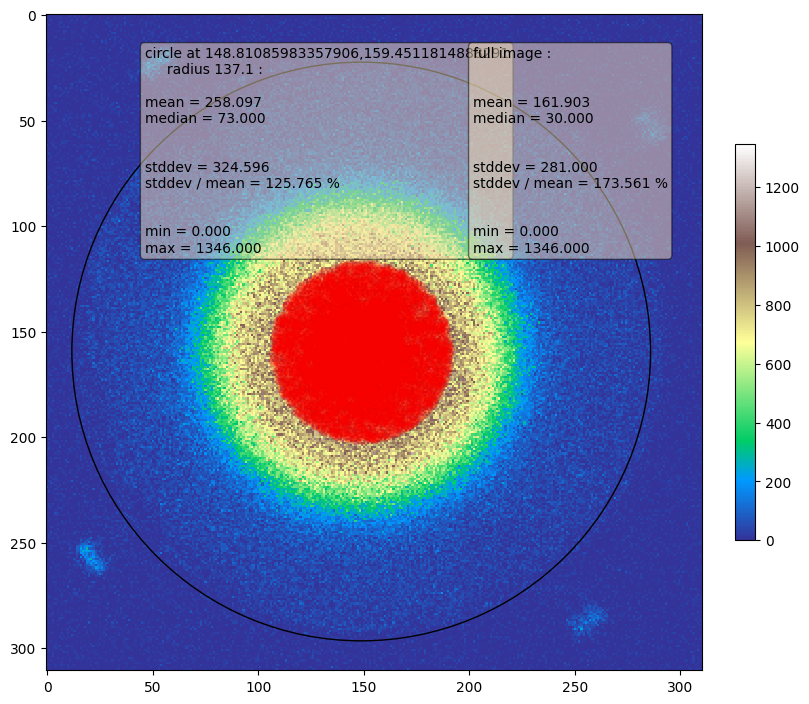

In [52]:
det_id = 26
cm1 = center_of_mass_det(proton_det_cut_data.data[det_id])
cm1_circle = Circle(x=cm1[1], y=cm1[0], r=r_px)
fig, ax = plot_data_simple(proton_det_cut_data.data[det_id].raw.image, circle_px=cm1_circle, clip=False)
for circle_no in range(num_circles):
    circle = Circle(x=cm1_circle.x + shift_x[circle_no], y=cm1_circle.y + shift_y[circle_no], r=small_radius)
    ax.plot(circle.x, circle.y, 'o', color='red', alpha=0.1)

In [53]:
df_data = defaultdict(list)
for data in proton_det_sel_data.data.values():
    cm1 = center_of_mass_det(data)
    cm1_circle = Circle(x=cm1[1], y=cm1[0], r=r_px)
    for circle_no in range(num_circles):
        circle = Circle(x=cm1_circle.x + shift_x[circle_no], y=cm1_circle.y + shift_y[circle_no], r=small_radius)
        mask = create_circular_mask(img=data.raw.image, circle_px=circle)
        df_data["det_no"] += [int(data.det_no)]
        df_data["mean_signal"] += [np.mean(data.raw.image[mask])]
        df_data["std_signal"] += [np.std(data.raw.image[mask])]
        df_data["radiation"] += ["proton"]
        df_data["circle_no"] += [circle_no]
# for data in co60_det_sel_data.data.values():
#     for circle_no in range(num_circles):
#         circle = Circle(x=data.circle.x + shift_x[circle_no], y=data.circle.y + shift_y[circle_no], r=small_radius)
#         mask = create_circular_mask(img=data.raw.image, circle_px=circle)
#         df_data["det_no"] += [int(data.det_no)]
#         df_data["mean_signal"] += [np.mean(data.raw.image[mask])]
#         df_data["std_signal"] += [np.std(data.raw.image[mask])]
#         df_data["radiation"] += ["Co60"]
#         df_data["circle_no"] += [circle_no]
df = pd.DataFrame(df_data)
df.sort_values(by=["radiation","det_no"], inplace=True)
df

det_no  mean_signal  std_signal radiation  circle_no
0          26   877.658147  123.164640    proton          0
1          26   887.311321  112.692214    proton          1
2          26   897.546624  114.089871    proton          2
3          26   911.924290  119.489136    proton          3
4          26   891.531847  103.260511    proton          4
...       ...          ...         ...       ...        ...
29995      28   848.313291  115.179304    proton       9995
29996      28   842.485623  106.470446    proton       9996
29997      28   869.902516  101.158198    proton       9997
29998      28   816.239617  109.627441    proton       9998
29999      28   871.325949  105.181691    proton       9999

[30000 rows x 5 columns]

<Axes: xlabel='mean_signal', ylabel='Count'>

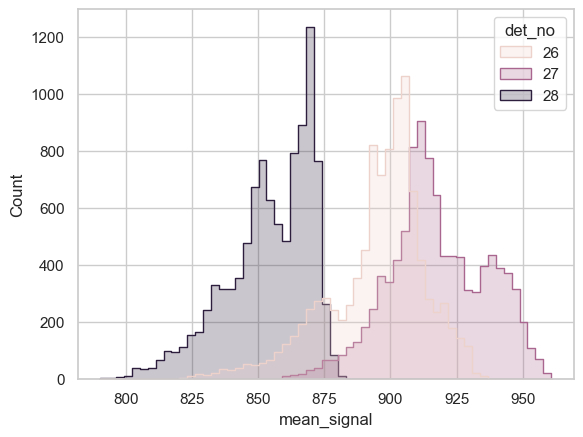

In [54]:
sns.set_theme(style="whitegrid")
sns.histplot(x="mean_signal", hue="det_no", data=df, element='step')

In [55]:
df2 = pd.DataFrame()
df2["mean"] = df.groupby(["radiation", "det_no"])["mean_signal"].mean()
df2["std"] = df.groupby(["radiation", "det_no"])["mean_signal"].std()
df2

mean        std
radiation det_no                       
proton    26      894.987122  18.641467
          27      917.609262  18.467807
          28      854.045556  16.051819

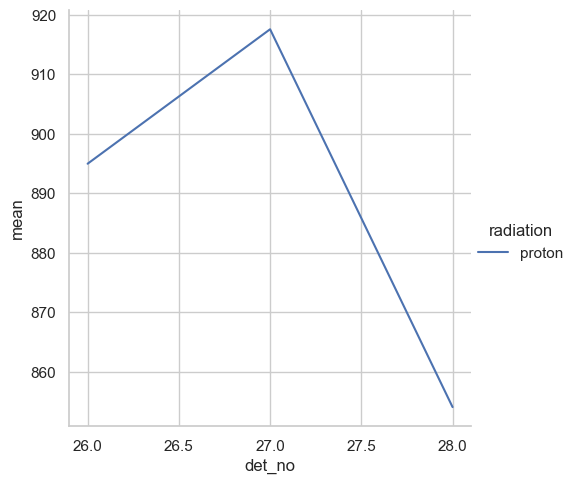

In [56]:
sns.relplot(data=df2.reset_index(), x='det_no', y='mean', hue='radiation', style='radiation', kind='line')

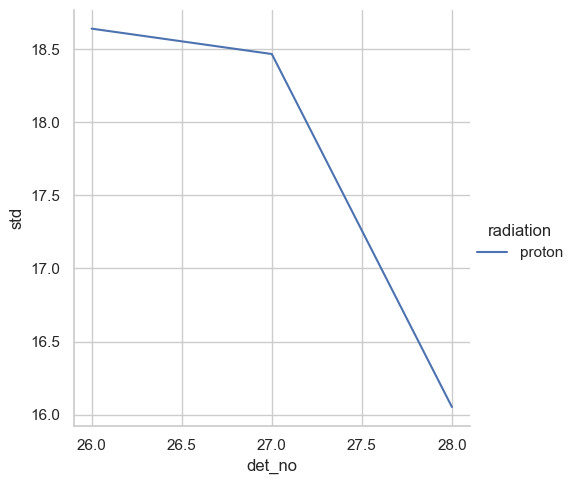

In [57]:
sns.relplot(data=df2.reset_index(), x='det_no', y='std', hue='radiation', style='radiation', kind='line')

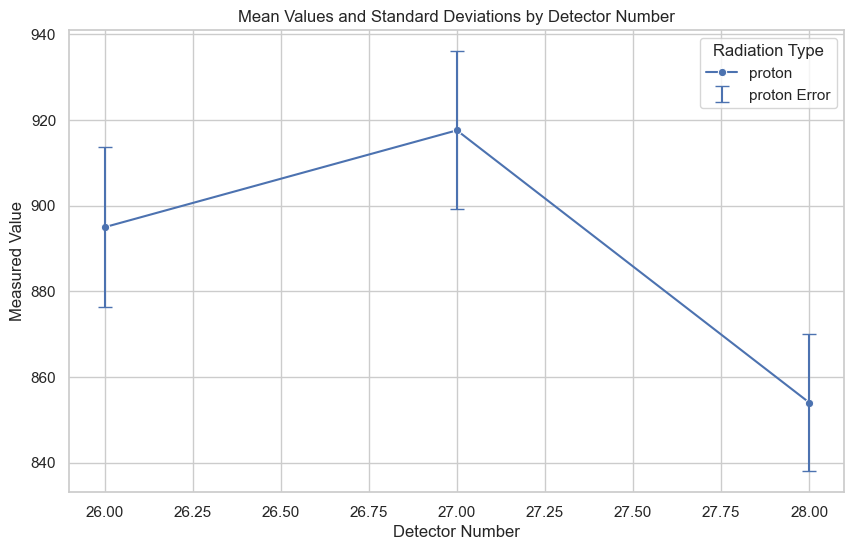

In [58]:
# Reset the index if df2 is a MultiIndex DataFrame
df2_reset = df2.reset_index()
df2_reset = df2_reset[df2_reset.det_no <= 28]

# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Plot the mean values with line and scatter points
sns.lineplot(data=df2_reset, x='det_no', y='mean', hue='radiation', style='radiation', markers=True, dashes=False)

# Add error bars
for radiation_type in df2_reset['radiation'].unique():
    subset = df2_reset[df2_reset['radiation'] == radiation_type]
    plt.errorbar(subset['det_no'], subset['mean'], yerr=subset['std'], fmt='none', capsize=5, label=f'{radiation_type} Error')

plt.title('Mean Values and Standard Deviations by Detector Number')
plt.xlabel('Detector Number')
plt.ylabel('Measured Value')
plt.legend(title='Radiation Type')

In [59]:
df.to_hdf(base_output_path / 'data_mb_ebt3.h5', key='df', mode='w')

# Dose dependency selection

In [60]:
det_data_dict = {}
for data in proton_det_cut_data.data.values():
    if data.det_no > 28:
        det_data_dict[data.det_no] = data
        print(f"{data.det_no} ", end='')
proton_det_sel_data = DetectorDataCollection(path=proton_det_cut_data.path, data=det_data_dict)

29 30 31 32 33 34 

In [61]:
# det_data_dict = {}
# for data in co60_det_cut_data.data.values():
#     if data.det_no >= 2 and data.det_no <= 15:
#         det_data_dict[data.det_no] = data
#         print(f"{data.det_no} ", end='')
# co60_det_sel_data = DetectorDataCollection(path=co60_det_cut_data.path, data=det_data_dict)

In [62]:
num_circles = 10000
small_radius = 10
shift_x, shift_y = [], []
min_radius_all = 130

center_max_radius_px = 0.8*min_radius_all-small_radius
center_max_radius_mm = center_max_radius_px * px_to_mm

for _ in range(num_circles):
    angle = random.uniform(0, 2*np.pi)
    distance_sq = random.uniform(0, center_max_radius_px**2)
    shift_x.append((distance_sq**0.5) * math.cos(angle))
    shift_y.append((distance_sq**0.5) * math.sin(angle))

center_max_radius_mm

6.856309297226348

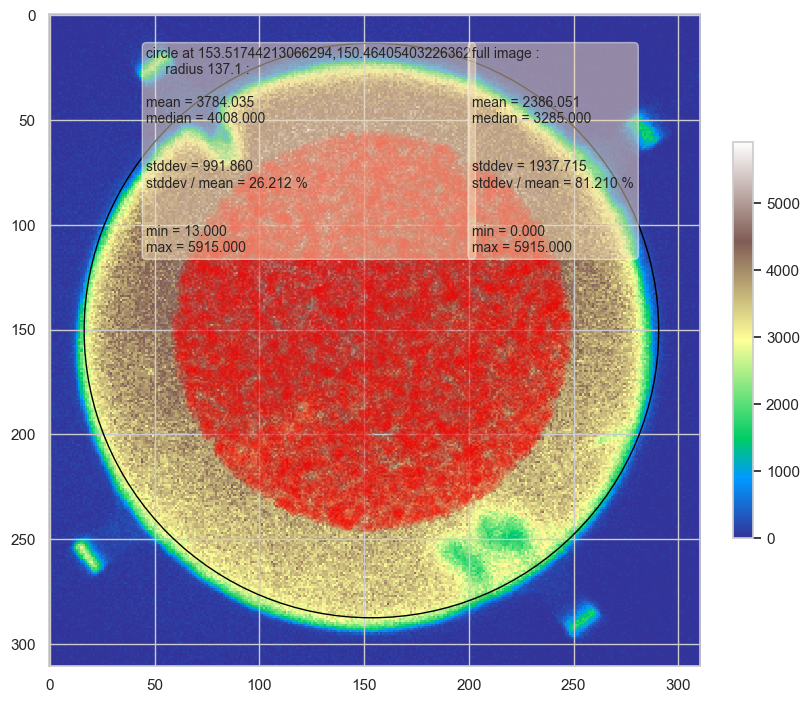

In [63]:
det_id = 34
cm1 = center_of_mass_det(proton_det_cut_data.data[det_id])
cm1_circle = Circle(x=cm1[1], y=cm1[0], r=r_px)
fig, ax = plot_data_simple(proton_det_cut_data.data[det_id].raw.image, circle_px=cm1_circle, clip=False)
for circle_no in range(num_circles):
    circle = Circle(x=cm1_circle.x + shift_x[circle_no], y=cm1_circle.y + shift_y[circle_no], r=small_radius)
    ax.plot(circle.x, circle.y, 'o', color='red', alpha=0.1)

In [64]:
df_data = defaultdict(list)
for data in proton_det_sel_data.data.values():
    cm1 = center_of_mass_det(data)
    cm1_circle = Circle(x=cm1[1], y=cm1[0], r=r_px)
    for circle_no in range(num_circles):
        circle = Circle(x=cm1_circle.x + shift_x[circle_no], y=cm1_circle.y + shift_y[circle_no], r=small_radius)
        mask = create_circular_mask(img=data.raw.image, circle_px=circle)
        df_data["det_no"] += [int(data.det_no)]
        df_data["mean_signal"] += [np.mean(data.raw.image[mask])]
        df_data["std_signal"] += [np.std(data.raw.image[mask])]
        df_data["radiation"] += ["proton"]
        df_data["circle_no"] += [circle_no]
# for data in co60_det_sel_data.data.values():
#     for circle_no in range(num_circles):
#         circle = Circle(x=data.circle.x + shift_x[circle_no], y=data.circle.y + shift_y[circle_no], r=small_radius)
#         mask = create_circular_mask(img=data.raw.image, circle_px=circle)
#         df_data["det_no"] += [int(data.det_no)]
#         df_data["mean_signal"] += [np.mean(data.raw.image[mask])]
#         df_data["std_signal"] += [np.std(data.raw.image[mask])]
#         df_data["radiation"] += ["Co60"]
#         df_data["circle_no"] += [circle_no]
df = pd.DataFrame(df_data)
df.sort_values(by=["radiation","det_no"], inplace=True)
df

det_no  mean_signal  std_signal radiation  circle_no
0          29   221.731861   58.014471    proton          0
1          29   212.784810   54.735132    proton          1
2          29   222.337539   55.017430    proton          2
3          29   226.742038   59.534663    proton          3
4          29   234.853503   55.143798    proton          4
...       ...          ...         ...       ...        ...
59995      34  4258.531646  266.287645    proton       9995
59996      34  4491.275641  272.030743    proton       9996
59997      34  4114.286624  240.652975    proton       9997
59998      34  4054.741325  253.235061    proton       9998
59999      34  3904.063694  266.615785    proton       9999

[60000 rows x 5 columns]

<Axes: xlabel='mean_signal', ylabel='Count'>

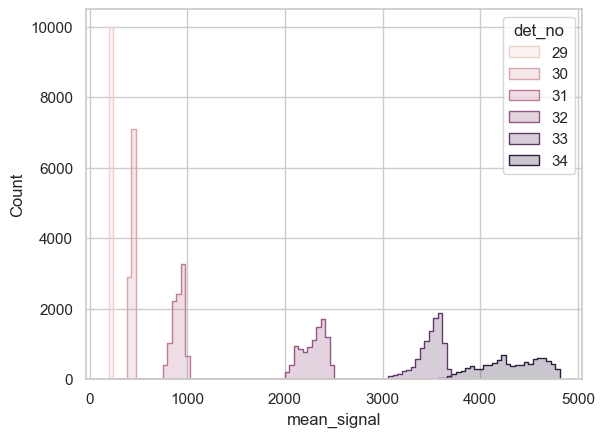

In [65]:
sns.set_theme(style="whitegrid")
sns.histplot(x="mean_signal", hue="det_no", data=df, element='step', bins=100)

In [66]:
df2 = pd.DataFrame()
df2["mean"] = df.groupby(["radiation", "det_no"])["mean_signal"].mean()
df2["std"] = df.groupby(["radiation", "det_no"])["mean_signal"].std()
df2

mean         std
radiation det_no                         
proton    29       224.562742    8.510469
          30       436.818510   17.632051
          31       908.362253   57.278782
          32      2288.204456  120.826034
          33      3489.594066  128.071067
          34      4313.157992  300.440732

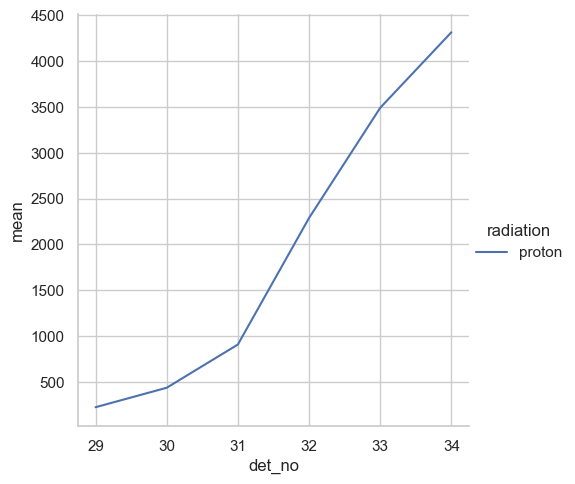

In [67]:
sns.relplot(data=df2.reset_index(), x='det_no', y='mean', hue='radiation', style='radiation', kind='line')

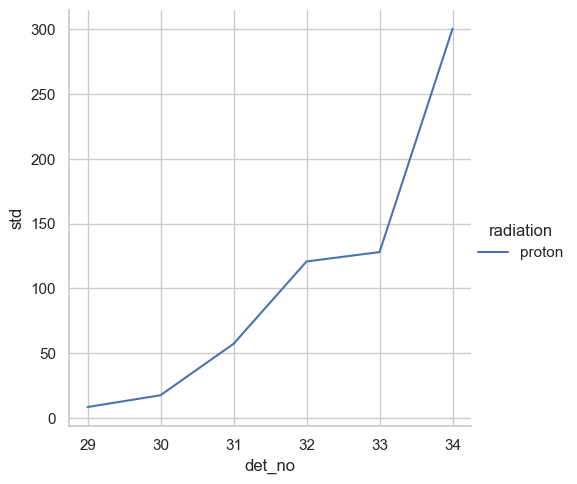

In [68]:
sns.relplot(data=df2.reset_index(), x='det_no', y='std', hue='radiation', style='radiation', kind='line')

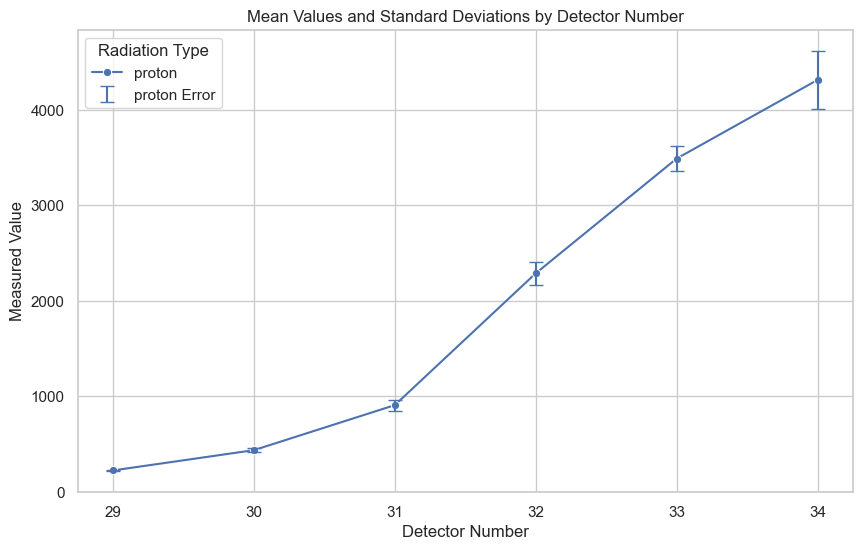

In [69]:
# Reset the index if df2 is a MultiIndex DataFrame
df2_reset = df2.reset_index()
df2_reset = df2_reset[df2_reset.det_no > 28]

# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Plot the mean values with line and scatter points
sns.lineplot(data=df2_reset, x='det_no', y='mean', hue='radiation', style='radiation', markers=True, dashes=False)

# Add error bars
for radiation_type in df2_reset['radiation'].unique():
    subset = df2_reset[df2_reset['radiation'] == radiation_type]
    plt.errorbar(subset['det_no'], subset['mean'], yerr=subset['std'], fmt='none', capsize=5, label=f'{radiation_type} Error')

plt.title('Mean Values and Standard Deviations by Detector Number')
plt.xlabel('Detector Number')
plt.ylabel('Measured Value')
plt.legend(title='Radiation Type')

In [70]:
df.to_hdf(base_output_path / 'data_mb_dose.h5', key='df', mode='w')